In [ ]:
! pip install lime

In [179]:
# Classic data science libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import files
import lime
from PIL import Image
import requests

# Torch libaries 
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models.resnet import ResNet18_Weights

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print('Device:', device)

Device: cuda


In [7]:
# set random seed
np.random.seed(10)

In [11]:
# Define Birds dataset class
class BirdsDataset(Dataset):
    def __init__(self, path, transform=None):
        # Check if we have the dataset
        if 'birds' not in os.listdir('./'):
            print('Dataset is not exist. You must download it.')
        else:
            self.data = ImageFolder(root=path, transform=transform)
            self.classes = self.data.classes
            self.transform = transform

    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

    def __len__(self):
        return len(self.data)

    def download():
        if 'birds' not in os.listdir('./'):
            files.upload()
            os.system('mkdir ~/.kaggle')
            os.system('cp kaggle.json ~/.kaggle/')
            os.system('chmod 600 ~/.kaggle/kaggle.json')
            os.system('kaggle datasets download -d gpiosenka/100-bird-species')
            os.system('unzip 100-bird-species.zip -d birds')
            print('The dataset has been downloaded.')
        else:
            print('The dataset already exists.')

In [12]:
# Download the dataset
BirdsDataset.download()

The dataset already exists.


In [13]:
# Set configurations
class CONFIG:
    # Paths
    ROOT_PATH   = Path('./birds')
    TRAIN_DIR   = ROOT_PATH.joinpath('train')
    VALID_DIR   = ROOT_PATH.joinpath('valid')
    TEST_DIR    = ROOT_PATH.joinpath('test')
    # Constants of datasets
    TARGET_SIZE = (224, 224)
    CHANNELS    = 3
    INPUT_SHAPE = (CHANNELS, *TARGET_SIZE)
    NUM_CLASSES = 500
    # Constants of training
    BATCH_SIZE  = 128

In [14]:
# Define the data transformations

# for train/valid
train_transform = transforms.Compose([
    transforms.Resize(CONFIG.TARGET_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# for test
test_transform = transforms.Compose([
    transforms.Resize((CONFIG.TARGET_SIZE)),
    transforms.ToTensor(),
])

# Load the data and apply transformations
TRAINSET = BirdsDataset(CONFIG.TRAIN_DIR, transform=train_transform)
VALIDSET = BirdsDataset(CONFIG.VALID_DIR, transform=train_transform)
TESTSET = BirdsDataset(CONFIG.TEST_DIR, transform=test_transform)

Original image


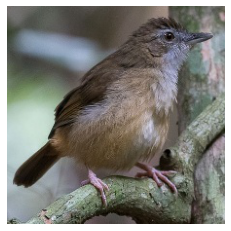

After some transformations


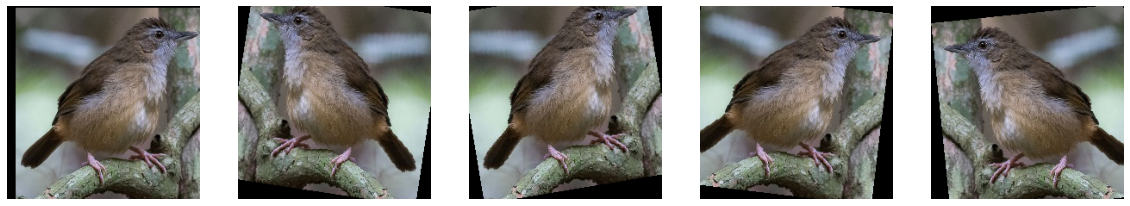

In [15]:
# Show exmples of transformations
print('Original image')
img = TESTSET[4][0]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

print('After some transformations')
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_transform(transforms.ToPILImage()(img)).permute(1, 2, 0))
    ax.axis('off')
plt.show()

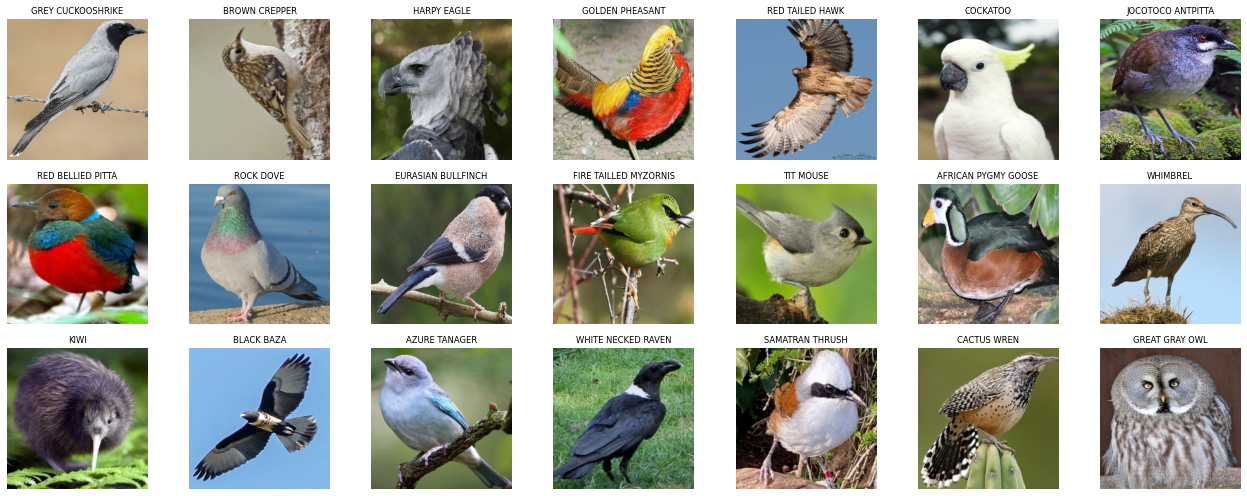

In [16]:
# Plot some examples
random_index = np.random.randint(0, len(TESTSET), 21)
fig, axes = plt.subplots(nrows=3, ncols=7,figsize=(18, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(TESTSET[random_index[i]][0].permute(1, 2, 0))
    ax.set_title(TESTSET.classes[TESTSET[random_index[i]][1]], fontsize='small')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Set dataloaders
train_dataloader = DataLoader(TRAINSET, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(VALIDSET, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(TESTSET, batch_size=CONFIG.BATCH_SIZE, shuffle=True)

In [ ]:
# Download and load the pre-trained ResNet-18 model
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
# add our costum output layer
model.fc = torch.nn.Linear(model.fc.in_features, CONFIG.NUM_CLASSES)
# show model architecture
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters())
print(f"The model has {num_params:,} parameters.")

The model has 11,433,012 parameters.


In [ ]:
# test the Network 
data = torch.randn(1, *CONFIG.INPUT_SHAPE)
model(data).shape

torch.Size([1, 500])

In [22]:
# set loss_fct and optimizer 
loss_fct = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [ ]:
# move model to gpu/cpu
model.to(device)

# Training loop
for epoch in range(10):
    model.train()  # Set the model to training mode
    train_correct = 0.0
    train_loss = 0.0
    total = 0.0
    for i, batch in enumerate(train_dataloader):
        images, labels = batch
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = loss_fct(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels.to(device)).sum().item()
        accuracy = train_correct * 100 / total
        if i % 100 == 99:
            print('[Epoch %d, Batch %d] Train Loss: %.3f, Train Accuracy: %.2f%%' % (epoch + 1, i + 1, train_loss / 100, accuracy))
            train_loss = 0.0
            train_correct = 0
            total = 0

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    valid_correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_dataloader):
            outputs = model(images.to(device))
            loss = loss_fct(outputs.to(device), labels.to(device))
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            valid_correct += (predicted == labels.to(device)).sum().item()
        accuracy = 100 * valid_correct / total
        print('[Epoch %d] Valid Loss: %.3f, Valid Accuracy: %.2f%%' % (epoch + 1, valid_loss / len(valid_dataloader), accuracy))
        torch.save(model, f'./model_epoch{epoch+1}.pth')

print('Finished training')

[Epoch 1, Batch 100] Train Loss: 4.442, Train Accuracy: 19.42%
[Epoch 1, Batch 200] Train Loss: 2.019, Train Accuracy: 56.09%
[Epoch 1, Batch 300] Train Loss: 1.331, Train Accuracy: 69.05%
[Epoch 1, Batch 400] Train Loss: 1.070, Train Accuracy: 73.98%
[Epoch 1, Batch 500] Train Loss: 0.962, Train Accuracy: 76.50%
[Epoch 1, Batch 600] Train Loss: 0.835, Train Accuracy: 78.89%
[Epoch 1] Valid Loss: 0.788, Valid Accuracy: 79.72%
[Epoch 2, Batch 100] Train Loss: 0.629, Train Accuracy: 83.71%
[Epoch 2, Batch 200] Train Loss: 0.621, Train Accuracy: 83.78%
[Epoch 2, Batch 300] Train Loss: 0.602, Train Accuracy: 83.79%
[Epoch 2, Batch 400] Train Loss: 0.586, Train Accuracy: 84.55%
[Epoch 2, Batch 500] Train Loss: 0.584, Train Accuracy: 84.68%
[Epoch 2, Batch 600] Train Loss: 0.556, Train Accuracy: 85.12%
[Epoch 2] Valid Loss: 0.479, Valid Accuracy: 86.52%
[Epoch 3, Batch 100] Train Loss: 0.425, Train Accuracy: 88.77%
[Epoch 3, Batch 200] Train Loss: 0.435, Train Accuracy: 88.04%
[Epoch 3, Batc

In [23]:
# Load the saved model
model = torch.load('./model_epoch9.pth')
model.to(device)

# Validation loop 
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
total = 0 
with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        outputs = model(images.to(device))
        loss = loss_fct(outputs.to(device), labels.to(device))
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (predicted == labels.to(device)).sum().item()
    accuracy = 100 * test_correct / total
print('Test Loss: %.3f, Test Accuracy: %.2f%%' % (test_loss / len(valid_dataloader), accuracy))

Test Loss: 0.202, Test Accuracy: 95.04%


In [83]:
def predict_fn(input):
    # Set the model to evaluation mode
    model.eval()
    # Make predictions on the input data
    with torch.no_grad():
        return nn.functional.softmax(model(input), dim=1)

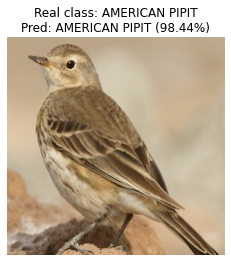

In [152]:
img, label = TESTSET[100]
prediction = predict_fn(img.view(1, *CONFIG.INPUT_SHAPE).to(device))
p, p_label = torch.max(prediction, 1)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Real class: {TESTSET.classes[label]}\nPred: {TESTSET.classes[label]} ({100 * p[0].item():.2f}%)')
plt.show()

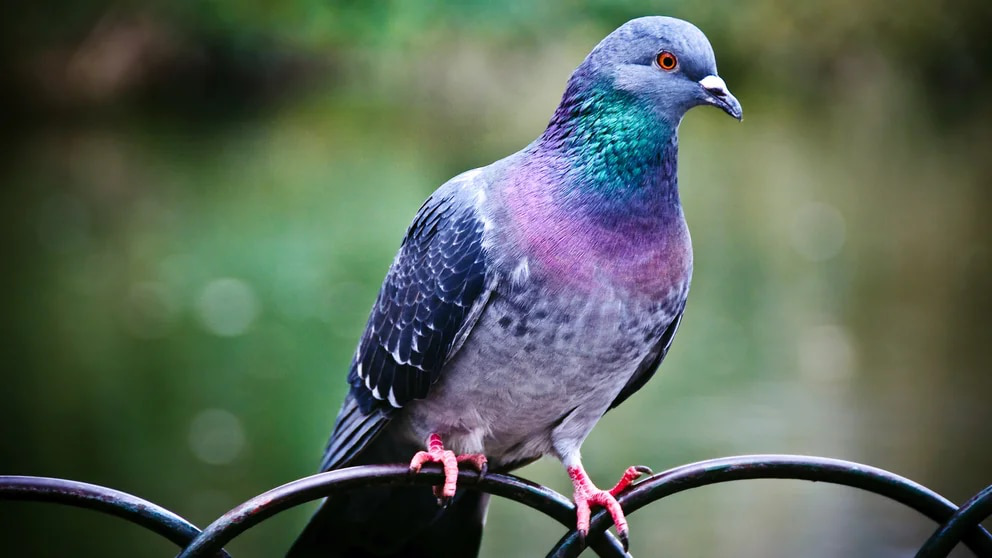

In [180]:
# get image from url
url = 'https://www.infobae.com/new-resizer/nCfMey09hVtkpZ9MxSMSv-G_eXI=/992x558/filters:format(webp):quality(85)/s3.amazonaws.com/arc-wordpress-client-uploads/infobae-wp/wp-content/uploads/2016/09/27174918/Paloma1.jpg'
img_pil = Image.open(requests.get(url, stream=True).raw)
img_pil

After transformation


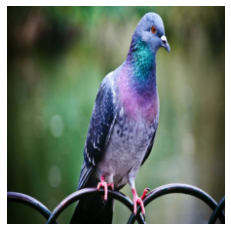

In [193]:
# Apply transformation
img_tensor = test_transform(img_pil)
print('After transformation')
plt.imshow(img_tensor.permute(1,2,0))
plt.axis('off')
plt.show()

In [194]:
# Predict & print the result
prediction = predict_fn(img_tensor.view(1, *CONFIG.INPUT_SHAPE).to(device))
p, p_label = torch.max(prediction, 1)
print('Pred:', TESTSET.classes[p_label], f'({(p[0].item() * 100):.2f}%)')

Pred: ROCK DOVE (99.94%)
